# EfficientNet Test

- https://github.com/lukemelas/EfficientNet-PyTorch/blob/master/examples/simple/example.ipynb

In [62]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b5')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /home/jpark/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:25<00:00, 4.78MB/s] 


Loaded pretrained weights for efficientnet-b5


In [27]:
model = EfficientNet.from_pretrained("efficientnet-b7", advprop=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth" to /home/jpark/.cache/torch/hub/checkpoints/adv-efficientnet-b7-4652b6dd.pth
100%|██████████| 255M/255M [01:28<00:00, 3.01MB/s] 


Loaded pretrained weights for efficientnet-b7


In [30]:
import json
from PIL import Image
import torch
from torchvision import transforms

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2')

# Preprocess image
tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(Image.open('img4doc/apple3.jpg')).unsqueeze(0)
print(img.shape) # torch.Size([1, 3, 224, 224])

# Load ImageNet class names
labels_map = json.load(open('img4doc/labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]

# Classify
model.eval()
with torch.no_grad():
    outputs = model(img)

# Print predictions
print('-----')
for idx in torch.topk(outputs, k=5).indices.squeeze(0).tolist():
    prob = torch.softmax(outputs, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=labels_map[idx], p=prob*100))

Loaded pretrained weights for efficientnet-b2
torch.Size([1, 3, 224, 306])
-----
Granny Smith                                                                (56.04%)
pomegranate                                                                 (3.66%)
orange                                                                      (2.60%)
banana                                                                      (1.10%)
pineapple, ananas                                                           (0.99%)


## Test2

In [32]:
import json
from PIL import Image

import torch
from torchvision import transforms

from efficientnet_pytorch import EfficientNet

In [33]:
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name) # 224

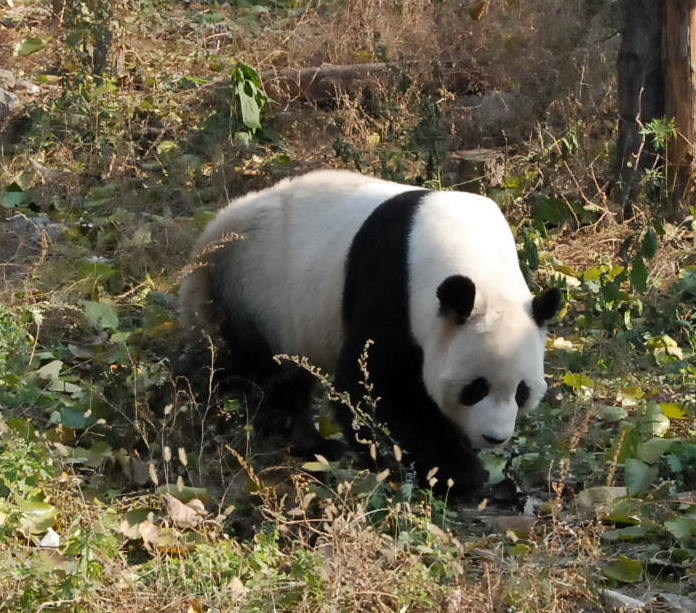

In [37]:
# Open image
img = Image.open('img4doc/img.jpg')
img

In [38]:
# Preprocess image
tfms = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), 
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(img).unsqueeze(0)

In [51]:
# Load class names
labels_map = json.load(open('./img4doc/labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]


In [52]:
# Classify with EfficientNet
model = EfficientNet.from_pretrained(model_name)
model.eval()
with torch.no_grad():
    logits = model(img)
preds = torch.topk(logits, k=5).indices.squeeze(0).tolist()

print('-----')
for idx in preds:
    label = labels_map[idx]
    prob = torch.softmax(logits, dim=1)[0, idx].item()
    print('{:<75} ({:.2f}%)'.format(label, prob*100))

Loaded pretrained weights for efficientnet-b0
-----
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca           (83.49%)
brown bear, bruin, Ursus arctos                                             (0.62%)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens         (0.60%)
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus                 (0.44%)
Arctic fox, white fox, Alopex lagopus                                       (0.34%)


## Tensorflow consistency check

In [53]:
import json
from PIL import Image

import torch
import tensorflow as tf

from efficientnet_pytorch import EfficientNet

In [54]:
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name) # 224

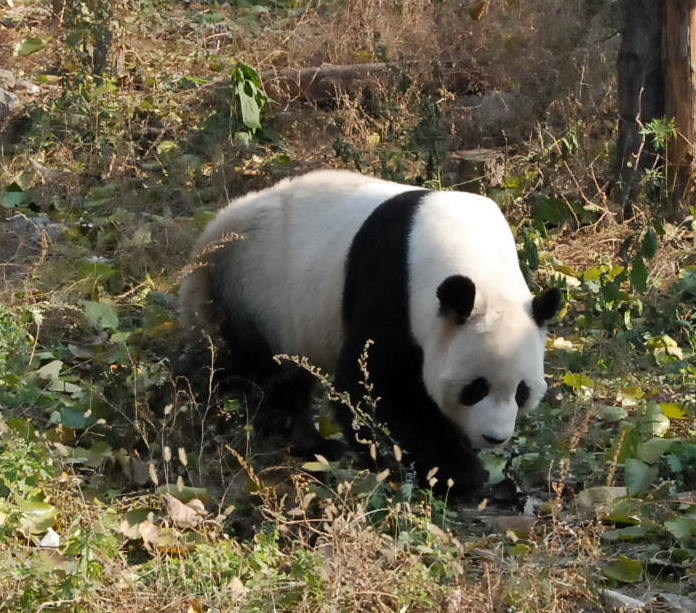

In [56]:
# Show image
Image.open('img4doc/img.jpg')

In [57]:
# Preprocess image with TensorFlow
tf.enable_eager_execution()

# Constants
MEAN_RGB = [0.485 * 255, 0.456 * 255, 0.406 * 255]
STDDEV_RGB = [0.229 * 255, 0.224 * 255, 0.225 * 255]
CROP_PADDING = 32
image_size = 224

# Helper function
def _decode_and_center_crop(image_bytes, image_size):
    shape = tf.image.extract_jpeg_shape(image_bytes)
    image_height = shape[0]
    image_width = shape[1]
    padded_center_crop_size = tf.cast(
      ((image_size / (image_size + CROP_PADDING)) *
       tf.cast(tf.minimum(image_height, image_width), tf.float32)),
      tf.int32)
    offset_height = ((image_height - padded_center_crop_size) + 1) // 2
    offset_width = ((image_width - padded_center_crop_size) + 1) // 2
    crop_window = tf.stack([offset_height, offset_width, padded_center_crop_size, padded_center_crop_size])
    image = tf.image.decode_and_crop_jpeg(image_bytes, crop_window, channels=3)
    image = tf.image.resize_bicubic([image], [image_size, image_size])[0]
    return image

# Process
tf_img_bytes = tf.read_file('img.jpg')
tf_img = _decode_and_center_crop(tf_img_bytes, image_size)
tf_img = tf.image.resize_bicubic([tf_img], [image_size, image_size])[0] # ok it matches up to here
use_bfloat16 = 224 # bug in the original repo! 
tf_img = tf.image.convert_image_dtype(tf_img, dtype=tf.bfloat16 if use_bfloat16 else tf.float32)
tf_img = tf.cast(tf_img, tf.float32)
tf_img = (tf_img - MEAN_RGB) / (STDDEV_RGB)  # this is exactly the input to the model
img = torch.from_numpy(tf_img.numpy()).unsqueeze(0).permute((0,3,1,2))


AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'

In [58]:
# Load class names
labels_map = json.load(open('labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]

FileNotFoundError: [Errno 2] No such file or directory: 'labels_map.txt'

In [59]:
# Classify with EfficientNet
model = EfficientNet.from_pretrained(model_name)
model.eval()
with torch.no_grad():
    logits = model(img)
preds = torch.topk(logits, k=5).indices.squeeze(0).tolist()

print('-----')
for idx in preds:
    label = labels_map[idx]
    prob = torch.softmax(logits, dim=1)[0, idx].item()
    print('{:<75} ({:.2f}%)'.format(label, prob*100))


Loaded pretrained weights for efficientnet-b0
-----
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca           (83.49%)
brown bear, bruin, Ursus arctos                                             (0.62%)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens         (0.60%)
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus                 (0.44%)
Arctic fox, white fox, Alopex lagopus                                       (0.34%)
